# Stock purchase recommendations with Machine Learning

In [1]:
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook # progress bar
import fastparquet

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.set_option('display.max_columns', 1500)

## Machine Learning

In [3]:
# load the df_Xy dataframe from feature engineering step:
df_Xy = fastparquet.ParquetFile('../data/interim/df_Xy_all_tickers_final.parq').to_pandas()

# split df into features and target (column setup_for_profitable_trade)
df_X = df_Xy.drop(columns=['setup_for_profitable_trade'])
df_y = df_Xy['setup_for_profitable_trade']

df_X.shape

(8780, 693)

### Build Model

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, shuffle=False)

In [5]:
X_train.tail()

,AdjVolume_-19,AdjVolume_-18,AdjVolume_-17,AdjVolume_-16,AdjVolume_-15,AdjVolume_-14,AdjVolume_-13,AdjVolume_-12,AdjVolume_-11,AdjVolume_-10,AdjVolume_-9,AdjVolume_-8,AdjVolume_-7,AdjVolume_-6,AdjVolume_-5,AdjVolume_-4,AdjVolume_-3,AdjVolume_-2,AdjVolume_-1,AdjVolume_0,AdjOpen_-19,AdjOpen_-18,AdjOpen_-17,AdjOpen_-16,AdjOpen_-15,AdjOpen_-14,AdjOpen_-13,AdjOpen_-12,AdjOpen_-11,AdjOpen_-10,AdjOpen_-9,AdjOpen_-8,AdjOpen_-7,AdjOpen_-6,AdjOpen_-5,AdjOpen_-4,AdjOpen_-3,AdjOpen_-2,AdjOpen_-1,AdjOpen_0,AdjHigh_-19,AdjHigh_-18,AdjHigh_-17,AdjHigh_-16,AdjHigh_-15,AdjHigh_-14,AdjHigh_-13,AdjHigh_-12,AdjHigh_-11,AdjHigh_-10,AdjHigh_-9,AdjHigh_-8,AdjHigh_-7,AdjHigh_-6,AdjHigh_-5,AdjHigh_-4,AdjHigh_-3,AdjHigh_-2,AdjHigh_-1,AdjHigh_0,AdjLow_-19,AdjLow_-18,AdjLow_-17,AdjLow_-16,AdjLow_-15,AdjLow_-14,AdjLow_-13,AdjLow_-12,AdjLow_-11,AdjLow_-10,AdjLow_-9,AdjLow_-8,AdjLow_-7,AdjLow_-6,AdjLow_-5,AdjLow_-4,AdjLow_-3,AdjLow_-2,AdjLow_-1,AdjLow_0,AdjClose_-19,AdjClose_-18,AdjClose_-17,AdjClose_-16,AdjClose_-15,AdjClose_-14,AdjClose_-13,AdjClose_-12,AdjClose_-11,AdjClose_-10,AdjClose_-9,AdjClose_-8,AdjClose_-7,AdjClose_-6,AdjClose_-5,AdjClose_-4,AdjClose_-3,AdjClose_-2,AdjClose_-1,AdjClose_0,AdjCloseRSI14_-19,AdjCloseRSI14_-18,AdjCloseRSI14_-17,AdjCloseRSI14_-16,AdjCloseRSI14_-15,AdjCloseRSI14_-14,AdjCloseRSI14_-13,AdjCloseRSI14_-12,AdjCloseRSI14_-11,AdjCloseRSI14_-10,AdjCloseRSI14_-9,AdjCloseRSI14_-8,AdjCloseRSI14_-7,AdjCloseRSI14_-6,AdjCloseRSI14_-5,AdjCloseRSI14_-4,AdjCloseRSI14_-3,AdjCloseRSI14_-2,AdjCloseRSI14_-1,AdjCloseRSI14_0,RSI_above_80_-19,RSI_above_80_-18,RSI_above_80_-17,RSI_above_80_-16,RSI_above_80_-15,RSI_above_80_-14,RSI_above_80_-13,RSI_above_80_-12,RSI_above_80_-11,RSI_above_80_-10,RSI_above_80_-9,RSI_above_80_-8,RSI_above_80_-7,RSI_above_80_-6,RSI_above_80_-5,RSI_above_80_-4,RSI_above_80_-3,RSI_above_80_-2,RSI_above_80_-1,RSI_above_80_0,RSI_below_20_-19,RSI_below_20_-18,RSI_below_20_-17,RSI_below_20_-16,RSI_below_20_-15,RSI_below_20_-14,RSI_below_20_-13,RSI_below_20_-12,RSI_below_20_-11,RSI_below_20_-10,RSI_below_20_-9,RSI_below_20_-8,RSI_below_20_-7,RSI_below_20_-6,RSI_below_20_-5,RSI_below_20_-4,RSI_below_20_-3,RSI_below_20_-2,RSI_below_20_-1,RSI_below_20_0,AdjCloseSMA10_-19,AdjCloseSMA10_-18,AdjCloseSMA10_-17,AdjCloseSMA10_-16,AdjCloseSMA10_-15,AdjCloseSMA10_-14,AdjCloseSMA10_-13,AdjCloseSMA10_-12,AdjCloseSMA10_-11,AdjCloseSMA10_-10,AdjCloseSMA10_-9,AdjCloseSMA10_-8,AdjCloseSMA10_-7,AdjCloseSMA10_-6,AdjCloseSMA10_-5,AdjCloseSMA10_-4,AdjCloseSMA10_-3,AdjCloseSMA10_-2,AdjCloseSMA10_-1,AdjCloseSMA10_0,AdjCloseSMA10_to_AdjClose_ratio_-19,AdjCloseSMA10_to_AdjClose_ratio_-18,AdjCloseSMA10_to_AdjClose_ratio_-17,AdjCloseSMA10_to_AdjClose_ratio_-16,AdjCloseSMA10_to_AdjClose_ratio_-15,AdjCloseSMA10_to_AdjClose_ratio_-14,AdjCloseSMA10_to_AdjClose_ratio_-13,AdjCloseSMA10_to_AdjClose_ratio_-12,AdjCloseSMA10_to_AdjClose_ratio_-11,AdjCloseSMA10_to_AdjClose_ratio_-10,AdjCloseSMA10_to_AdjClose_ratio_-9,AdjCloseSMA10_to_AdjClose_ratio_-8,AdjCloseSMA10_to_AdjClose_ratio_-7,AdjCloseSMA10_to_AdjClose_ratio_-6,AdjCloseSMA10_to_AdjClose_ratio_-5,AdjCloseSMA10_to_AdjClose_ratio_-4,AdjCloseSMA10_to_AdjClose_ratio_-3,AdjCloseSMA10_to_AdjClose_ratio_-2,AdjCloseSMA10_to_AdjClose_ratio_-1,AdjCloseSMA10_to_AdjClose_ratio_0,AdjClose_above_AdjCloseSMA10_-19,AdjClose_above_AdjCloseSMA10_-18,AdjClose_above_AdjCloseSMA10_-17,AdjClose_above_AdjCloseSMA10_-16,AdjClose_above_AdjCloseSMA10_-15,AdjClose_above_AdjCloseSMA10_-14,AdjClose_above_AdjCloseSMA10_-13,AdjClose_above_AdjCloseSMA10_-12,AdjClose_above_AdjCloseSMA10_-11,AdjClose_above_AdjCloseSMA10_-10,AdjClose_above_AdjCloseSMA10_-9,AdjClose_above_AdjCloseSMA10_-8,AdjClose_above_AdjCloseSMA10_-7,AdjClose_above_AdjCloseSMA10_-6,AdjClose_above_AdjCloseSMA10_-5,AdjClose_above_AdjCloseSMA10_-4,AdjClose_above_AdjCloseSMA10_-3,AdjClose_above_AdjCloseSMA10_-2,AdjClose_above_AdjCloseSMA10_-1,AdjClose_above_AdjCloseSMA10_0,AdjClose_crossed_AdjCloseSMA10_-19,AdjClose_crossed_AdjCloseSMA10_-18,AdjClose_crossed_AdjCloseSMA10

In [6]:
X_test.head()

,AdjVolume_-19,AdjVolume_-18,AdjVolume_-17,AdjVolume_-16,AdjVolume_-15,AdjVolume_-14,AdjVolume_-13,AdjVolume_-12,AdjVolume_-11,AdjVolume_-10,AdjVolume_-9,AdjVolume_-8,AdjVolume_-7,AdjVolume_-6,AdjVolume_-5,AdjVolume_-4,AdjVolume_-3,AdjVolume_-2,AdjVolume_-1,AdjVolume_0,AdjOpen_-19,AdjOpen_-18,AdjOpen_-17,AdjOpen_-16,AdjOpen_-15,AdjOpen_-14,AdjOpen_-13,AdjOpen_-12,AdjOpen_-11,AdjOpen_-10,AdjOpen_-9,AdjOpen_-8,AdjOpen_-7,AdjOpen_-6,AdjOpen_-5,AdjOpen_-4,AdjOpen_-3,AdjOpen_-2,AdjOpen_-1,AdjOpen_0,AdjHigh_-19,AdjHigh_-18,AdjHigh_-17,AdjHigh_-16,AdjHigh_-15,AdjHigh_-14,AdjHigh_-13,AdjHigh_-12,AdjHigh_-11,AdjHigh_-10,AdjHigh_-9,AdjHigh_-8,AdjHigh_-7,AdjHigh_-6,AdjHigh_-5,AdjHigh_-4,AdjHigh_-3,AdjHigh_-2,AdjHigh_-1,AdjHigh_0,AdjLow_-19,AdjLow_-18,AdjLow_-17,AdjLow_-16,AdjLow_-15,AdjLow_-14,AdjLow_-13,AdjLow_-12,AdjLow_-11,AdjLow_-10,AdjLow_-9,AdjLow_-8,AdjLow_-7,AdjLow_-6,AdjLow_-5,AdjLow_-4,AdjLow_-3,AdjLow_-2,AdjLow_-1,AdjLow_0,AdjClose_-19,AdjClose_-18,AdjClose_-17,AdjClose_-16,AdjClose_-15,AdjClose_-14,AdjClose_-13,AdjClose_-12,AdjClose_-11,AdjClose_-10,AdjClose_-9,AdjClose_-8,AdjClose_-7,AdjClose_-6,AdjClose_-5,AdjClose_-4,AdjClose_-3,AdjClose_-2,AdjClose_-1,AdjClose_0,AdjCloseRSI14_-19,AdjCloseRSI14_-18,AdjCloseRSI14_-17,AdjCloseRSI14_-16,AdjCloseRSI14_-15,AdjCloseRSI14_-14,AdjCloseRSI14_-13,AdjCloseRSI14_-12,AdjCloseRSI14_-11,AdjCloseRSI14_-10,AdjCloseRSI14_-9,AdjCloseRSI14_-8,AdjCloseRSI14_-7,AdjCloseRSI14_-6,AdjCloseRSI14_-5,AdjCloseRSI14_-4,AdjCloseRSI14_-3,AdjCloseRSI14_-2,AdjCloseRSI14_-1,AdjCloseRSI14_0,RSI_above_80_-19,RSI_above_80_-18,RSI_above_80_-17,RSI_above_80_-16,RSI_above_80_-15,RSI_above_80_-14,RSI_above_80_-13,RSI_above_80_-12,RSI_above_80_-11,RSI_above_80_-10,RSI_above_80_-9,RSI_above_80_-8,RSI_above_80_-7,RSI_above_80_-6,RSI_above_80_-5,RSI_above_80_-4,RSI_above_80_-3,RSI_above_80_-2,RSI_above_80_-1,RSI_above_80_0,RSI_below_20_-19,RSI_below_20_-18,RSI_below_20_-17,RSI_below_20_-16,RSI_below_20_-15,RSI_below_20_-14,RSI_below_20_-13,RSI_below_20_-12,RSI_below_20_-11,RSI_below_20_-10,RSI_below_20_-9,RSI_below_20_-8,RSI_below_20_-7,RSI_below_20_-6,RSI_below_20_-5,RSI_below_20_-4,RSI_below_20_-3,RSI_below_20_-2,RSI_below_20_-1,RSI_below_20_0,AdjCloseSMA10_-19,AdjCloseSMA10_-18,AdjCloseSMA10_-17,AdjCloseSMA10_-16,AdjCloseSMA10_-15,AdjCloseSMA10_-14,AdjCloseSMA10_-13,AdjCloseSMA10_-12,AdjCloseSMA10_-11,AdjCloseSMA10_-10,AdjCloseSMA10_-9,AdjCloseSMA10_-8,AdjCloseSMA10_-7,AdjCloseSMA10_-6,AdjCloseSMA10_-5,AdjCloseSMA10_-4,AdjCloseSMA10_-3,AdjCloseSMA10_-2,AdjCloseSMA10_-1,AdjCloseSMA10_0,AdjCloseSMA10_to_AdjClose_ratio_-19,AdjCloseSMA10_to_AdjClose_ratio_-18,AdjCloseSMA10_to_AdjClose_ratio_-17,AdjCloseSMA10_to_AdjClose_ratio_-16,AdjCloseSMA10_to_AdjClose_ratio_-15,AdjCloseSMA10_to_AdjClose_ratio_-14,AdjCloseSMA10_to_AdjClose_ratio_-13,AdjCloseSMA10_to_AdjClose_ratio_-12,AdjCloseSMA10_to_AdjClose_ratio_-11,AdjCloseSMA10_to_AdjClose_ratio_-10,AdjCloseSMA10_to_AdjClose_ratio_-9,AdjCloseSMA10_to_AdjClose_ratio_-8,AdjCloseSMA10_to_AdjClose_ratio_-7,AdjCloseSMA10_to_AdjClose_ratio_-6,AdjCloseSMA10_to_AdjClose_ratio_-5,AdjCloseSMA10_to_AdjClose_ratio_-4,AdjCloseSMA10_to_AdjClose_ratio_-3,AdjCloseSMA10_to_AdjClose_ratio_-2,AdjCloseSMA10_to_AdjClose_ratio_-1,AdjCloseSMA10_to_AdjClose_ratio_0,AdjClose_above_AdjCloseSMA10_-19,AdjClose_above_AdjCloseSMA10_-18,AdjClose_above_AdjCloseSMA10_-17,AdjClose_above_AdjCloseSMA10_-16,AdjClose_above_AdjCloseSMA10_-15,AdjClose_above_AdjCloseSMA10_-14,AdjClose_above_AdjCloseSMA10_-13,AdjClose_above_AdjCloseSMA10_-12,AdjClose_above_AdjCloseSMA10_-11,AdjClose_above_AdjCloseSMA10_-10,AdjClose_above_AdjCloseSMA10_-9,AdjClose_above_AdjCloseSMA10_-8,AdjClose_above_AdjCloseSMA10_-7,AdjClose_above_AdjCloseSMA10_-6,AdjClose_above_AdjCloseSMA10_-5,AdjClose_above_AdjCloseSMA10_-4,AdjClose_above_AdjCloseSMA10_-3,AdjClose_above_AdjCloseSMA10_-2,AdjClose_above_AdjCloseSMA10_-1,AdjClose_above_AdjCloseSMA10_0,AdjClose_crossed_AdjCloseSMA10_-19,AdjClose_crossed_AdjCloseSMA10_-18,AdjClose_crossed_AdjCloseSMA10

In [7]:
pipeline = Pipeline([
    ('standardScaler', StandardScaler()),
    ('randomForest', RandomForestClassifier())
])
pipeline.get_params()

{'memory': None,
 'randomForest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'randomForest__bootstrap': True,
 'randomForest__class_weight': None,
 'randomForest__criterion': 'gini',
 'randomForest__max_depth': None,
 'randomForest__max_features': 'auto',
 'randomForest__max_leaf_nodes': None,
 'randomForest__min_impurity_decrease': 0.0,
 'randomForest__min_impurity_split': None,
 'randomForest__min_samples_leaf': 1,
 'randomForest__min_samples_split': 2,
 'randomForest__min_weight_fraction_leaf': 0.0,
 'randomForest__n_estimators': 'warn',
 'randomForest__n_jobs': None,
 'randomForest__oob_score': F

In [8]:
pipeline.fit(X_train, y_train)

C:\Users\Lindstaedt\Anaconda3\envs\trader_env\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Lindstaedt\Anaconda3\envs\trader_env\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Lindstaedt\Anaconda3\envs\trader_env\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('standardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomForest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [9]:
y_pred_firstRF = pipeline.predict(X_test)

C:\Users\Lindstaedt\Anaconda3\envs\trader_env\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [10]:
print(classification_report(y_test, y_pred_firstRF))

              precision    recall  f1-score   support

       False       0.65      0.84      0.73      1153
        True       0.32      0.15      0.20       603

   micro avg       0.60      0.60      0.60      1756
   macro avg       0.49      0.49      0.47      1756
weighted avg       0.54      0.60      0.55      1756



In [11]:
accuracy_score(y_test, y_pred_firstRF)

0.6019362186788155

In [12]:
confusion_matrix(y_test, y_pred_firstRF, labels=[False, True])

array([[968, 185],
       [514,  89]], dtype=int64)

In [13]:
def print_feature_importances(estimator):

    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print(str(f + 1) + " importance: " + str(importances[indices[f]]) + ". feature name: " + X_train.columns[indices[f]])
        
print_feature_importances(pipeline.named_steps['randomForest'])

Feature ranking:
1 importance: 0.008092570630640896. feature name: AdjCloseSMA50_to_AdjCloseSMA200_ratio_-3
2 importance: 0.005663524717965971. feature name: AdjCloseSMA50_to_AdjCloseSMA200_ratio_-19
3 importance: 0.005653557511639618. feature name: AdjCloseSMA10_to_AdjCloseSMA50_ratio_-15
4 importance: 0.005377354181088602. feature name: AdjCloseSMA50_-7
5 importance: 0.005309519958529893. feature name: AdjCloseSMA50_chg_-17
6 importance: 0.005189186246729982. feature name: AdjCloseSMA10_to_AdjCloseSMA50_ratio_-18
7 importance: 0.005127987131951638. feature name: AdjCloseSMA50_to_AdjCloseSMA200_ratio_0
8 importance: 0.004991526069821011. feature name: AdjCloseSMA50_to_AdjCloseSMA200_ratio_-17
9 importance: 0.004880754775252084. feature name: AdjCloseSMA50_chg_-14
10 importance: 0.0048501818110517365. feature name: AdjCloseSMA200_-8
11 importance: 0.004801311240830151. feature name: AdjCloseSMA10_to_AdjCloseSMA50_ratio_-4
12 importance: 0.004798194835578101. feature name: week
13 impor

106 importance: 0.0027586576730021296. feature name: AdjCloseSMA50_to_AdjCloseSMA200_ratio_-12
107 importance: 0.0027525790564787707. feature name: AdjCloseSMA10_to_AdjClose_ratio_-13
108 importance: 0.0027495505396703986. feature name: AdjVolume_chg_-2
109 importance: 0.0027399149942627984. feature name: AdjCloseSMA200_to_AdjClose_ratio_-11
110 importance: 0.0027323135964109737. feature name: AdjCloseSMA200_chg_-18
111 importance: 0.002731124705059146. feature name: month
112 importance: 0.0027310364614960966. feature name: AdjHigh_chg_-9
113 importance: 0.0027232927446589135. feature name: AdjCloseSMA50_-18
114 importance: 0.002719935089204936. feature name: AdjClose_chg_-18
115 importance: 0.002710480111670569. feature name: AdjCloseSMA10_chg_-12
116 importance: 0.0027102218092546226. feature name: AdjHigh_chg_-18
117 importance: 0.0027087810468889237. feature name: AdjVolume_chg_-8
118 importance: 0.002708183272416283. feature name: AdjHigh_chg_-17
119 importance: 0.002703721802408

215 importance: 0.0020902120614946086. feature name: AdjLow_chg_-4
216 importance: 0.0020874990899131113. feature name: AdjCloseSMA50_chg_-7
217 importance: 0.002085802983947508. feature name: AdjVolume_-11
218 importance: 0.002078827278159926. feature name: AdjVolume_-3
219 importance: 0.002069215851500435. feature name: AdjCloseSMA50_to_AdjClose_ratio_-5
220 importance: 0.002068818999516952. feature name: AdjVolume_chg_-4
221 importance: 0.002068712478371415. feature name: AdjLow_chg_-2
222 importance: 0.0020622833365653787. feature name: AdjOpen_chg_-16
223 importance: 0.002052076486277773. feature name: AdjCloseSMA50_-10
224 importance: 0.002050423918642336. feature name: AdjOpen_chg_-6
225 importance: 0.0020483656116380257. feature name: AdjCloseSMA50_-13
226 importance: 0.0020463741256774434. feature name: AdjCloseRSI14_-3
227 importance: 0.002044253440316804. feature name: AdjHigh_-16
228 importance: 0.002039939693358477. feature name: AdjCloseSMA10_to_AdjCloseSMA50_ratio_-1
229

329 importance: 0.0015218524140307589. feature name: AdjLow_-7
330 importance: 0.001492787781307983. feature name: AdjCloseSMA10_chg_-5
331 importance: 0.0014874790701869835. feature name: AdjClose_chg_0
332 importance: 0.0014840235984201317. feature name: AdjLow_chg_-5
333 importance: 0.0014772226989310977. feature name: AdjHigh_-12
334 importance: 0.0014738191241183472. feature name: AdjCloseSMA10_-6
335 importance: 0.001463118485760428. feature name: AdjOpen_chg_-5
336 importance: 0.0014608412341696835. feature name: AdjOpen_-4
337 importance: 0.0014546394753684657. feature name: AdjLow_-6
338 importance: 0.0014543284244999666. feature name: AdjClose_-1
339 importance: 0.0014533377928958196. feature name: AdjCloseSMA50_-2
340 importance: 0.0014504099255691692. feature name: AdjCloseRSI14_-8
341 importance: 0.001446663258597053. feature name: AdjVolume_chg_-16
342 importance: 0.001443105311350133. feature name: AdjLow_-2
343 importance: 0.00144238862748718. feature name: AdjOpen_-5
3

445 importance: 0.00039875705492782825. feature name: AdjClose_crossed_AdjCloseSMA200_-1
446 importance: 0.0003974609168800406. feature name: AdjClose_above_AdjCloseSMA10_-8
447 importance: 0.000381486946817199. feature name: AdjClose_above_AdjCloseSMA10_-16
448 importance: 0.000366953318145712. feature name: AdjClose_above_AdjCloseSMA10_-4
449 importance: 0.00035254399863553275. feature name: AdjClose_above_AdjCloseSMA200_-2
450 importance: 0.00033848872413794553. feature name: AdjCloseSMA50_crossed_AdjCloseSMA10_-12
451 importance: 0.00031265355567504334. feature name: INTC.US
452 importance: 0.00030568396653949585. feature name: weekday
453 importance: 0.00029989063281918375. feature name: AdjClose_crossed_AdjCloseSMA10_-16
454 importance: 0.0002998902426444571. feature name: AdjCloseSMA200_crossed_AdjCloseSMA50_-9
455 importance: 0.0002966687747427299. feature name: AdjClose_above_AdjCloseSMA200_-1
456 importance: 0.00029394761968907926. feature name: AdjClose_crossed_AdjCloseSMA10

539 importance: 3.764327294121735e-05. feature name: AdjClose_crossed_AdjCloseSMA50_-4
540 importance: 3.320767619263024e-05. feature name: AdjClose_above_AdjCloseSMA50_-8
541 importance: 3.306761545865828e-05. feature name: AdjCloseSMA50_above_AdjCloseSMA10_-12
542 importance: 3.297856956393541e-05. feature name: AdjClose_above_AdjCloseSMA50_0
543 importance: 3.297856956393541e-05. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-18
544 importance: 3.297856956393541e-05. feature name: AdjClose_crossed_AdjCloseSMA200_-5
545 importance: 3.2541154507161824e-05. feature name: AdjClose_crossed_AdjCloseSMA200_-18
546 importance: 3.0435244799201315e-05. feature name: AdjClose_crossed_AdjCloseSMA10_-18
547 importance: 2.9980517785395866e-05. feature name: AdjClose_crossed_AdjCloseSMA50_-15
548 importance: 2.9081777770824922e-05. feature name: RSI_above_80_0
549 importance: 1.9716579193051276e-05. feature name: AdjCloseSMA50_crossed_AdjCloseSMA10_-11
550 importance: 1.940054137293623e-05. fea

656 importance: 0.0. feature name: RSI_above_80_-16
657 importance: 0.0. feature name: RSI_above_80_-18
658 importance: 0.0. feature name: RSI_above_80_-19
659 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-19
660 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-17
661 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-15
662 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-14
663 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-13
664 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-9
665 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-8
666 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-6
667 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-5
668 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-4
669 importance: 0.0. feature name: RSI_above_80_-3
670 importance: 0.0. feature name: RSI_above_80_-2
671 imp

### Improve RandomForest model

In [14]:
parameters = {
    'randomForest__min_samples_leaf': [1, 2, 5, 10]
}

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring='f1', n_jobs=-1, verbose=6)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.0min remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.0min finished
C:\Users\Lindstaedt\Anaconda3\envs\trader_env\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Lindstaedt\Anaconda3\envs\trader_env\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomForest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'randomForest__min_samples_leaf': [1, 2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=6)

In [15]:
cv.best_params_

{'randomForest__min_samples_leaf': 2}

In [16]:
print_feature_importances(cv.best_estimator_.named_steps['randomForest'])

Feature ranking:
1 importance: 0.006985479209232638. feature name: AdjCloseSMA50_to_AdjCloseSMA200_ratio_-7
2 importance: 0.006863097700419549. feature name: AdjCloseSMA50_chg_-18
3 importance: 0.0060790345449540555. feature name: AdjCloseSMA50_to_AdjCloseSMA200_ratio_-3
4 importance: 0.005554993641174766. feature name: week
5 importance: 0.005536564724854039. feature name: AdjCloseSMA50_-18
6 importance: 0.005421930260739041. feature name: AdjCloseSMA50_to_AdjCloseSMA200_ratio_-10
7 importance: 0.005313110997054302. feature name: AdjCloseSMA50_-17
8 importance: 0.0052888342273685555. feature name: AdjCloseSMA50_to_AdjCloseSMA200_ratio_-4
9 importance: 0.005203621190578543. feature name: AdjCloseSMA50_chg_-17
10 importance: 0.005159100000253914. feature name: AdjCloseSMA50_to_AdjCloseSMA200_ratio_-15
11 importance: 0.005052399855049833. feature name: AdjCloseSMA50_chg_0
12 importance: 0.005028365695682358. feature name: AdjCloseSMA200_-18
13 importance: 0.004783244883263049. feature na

106 importance: 0.0028173146988496192. feature name: AdjCloseSMA200_to_AdjClose_ratio_-16
107 importance: 0.0028126487327271043. feature name: AdjCloseSMA50_to_AdjClose_ratio_-16
108 importance: 0.0027972246683237085. feature name: AdjCloseSMA10_to_AdjCloseSMA50_ratio_-13
109 importance: 0.002789455990190239. feature name: AdjLow_-4
110 importance: 0.002772933359538357. feature name: day
111 importance: 0.0027664516209104225. feature name: AdjCloseSMA10_to_AdjCloseSMA50_ratio_-11
112 importance: 0.002755250008491664. feature name: AdjClose_-7
113 importance: 0.002754678642331625. feature name: AdjHigh_-8
114 importance: 0.0027528451969260075. feature name: AdjCloseSMA10_to_AdjClose_ratio_-11
115 importance: 0.0027406369316752056. feature name: AdjCloseSMA50_-7
116 importance: 0.002737880919225096. feature name: AdjClose_-10
117 importance: 0.0027154268070787692. feature name: AdjCloseSMA200_chg_-8
118 importance: 0.0027150973519700283. feature name: AdjCloseSMA10_to_AdjCloseSMA50_ratio

215 importance: 0.0020510575150421554. feature name: AdjClose_-13
216 importance: 0.0020507913251554795. feature name: AdjVolume_-9
217 importance: 0.002047541038658123. feature name: AdjCloseSMA200_chg_-5
218 importance: 0.002046721914689274. feature name: AdjClose_-15
219 importance: 0.002031690732492426. feature name: AdjCloseSMA10_chg_-4
220 importance: 0.0020302068592193885. feature name: AdjVolume_-2
221 importance: 0.0020285941394351968. feature name: AdjCloseRSI14_-13
222 importance: 0.0020269682877635453. feature name: AdjCloseSMA50_chg_-7
223 importance: 0.0020177374123941287. feature name: AdjHigh_-10
224 importance: 0.0020109438722866048. feature name: AdjHigh_-18
225 importance: 0.002008299162146129. feature name: AdjHigh_-6
226 importance: 0.0020076332606148535. feature name: AdjVolume_-3
227 importance: 0.0020069190504520503. feature name: AdjCloseSMA10_chg_-2
228 importance: 0.00200495129507977. feature name: AdjOpen_-1
229 importance: 0.001995396106205289. feature name

329 importance: 0.001540578788812034. feature name: AdjVolume_chg_-6
330 importance: 0.001540407820841015. feature name: AdjHigh_chg_-4
331 importance: 0.0015291486704665542. feature name: AdjCloseSMA200_chg_-9
332 importance: 0.0015211722620654638. feature name: AdjCloseRSI14_-14
333 importance: 0.0015206041598978834. feature name: AdjCloseSMA50_-4
334 importance: 0.001516457861070415. feature name: AdjVolume_-12
335 importance: 0.001511762998240316. feature name: AdjHigh_chg_0
336 importance: 0.0014937415533602314. feature name: AdjLow_chg_-14
337 importance: 0.001485320723876322. feature name: AdjCloseSMA50_-5
338 importance: 0.0014781400603066058. feature name: AdjLow_chg_-2
339 importance: 0.0014780116737624141. feature name: AdjVolume_chg_-16
340 importance: 0.0014720988071047151. feature name: AdjCloseSMA10_to_AdjClose_ratio_-7
341 importance: 0.0014626012873306684. feature name: AdjCloseSMA200_to_AdjClose_ratio_-2
342 importance: 0.0014537435957485945. feature name: AdjClose_ch

444 importance: 0.0004439764976584006. feature name: AdjClose_above_AdjCloseSMA10_-3
445 importance: 0.0004103968270010168. feature name: AdjClose_above_AdjCloseSMA10_-16
446 importance: 0.0003799017377412928. feature name: AdjClose_above_AdjCloseSMA10_-10
447 importance: 0.0003695166462993579. feature name: AdjClose_above_AdjCloseSMA200_-2
448 importance: 0.0003376994623793547. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-13
449 importance: 0.00032534725580967544. feature name: AdjCloseSMA50_crossed_AdjCloseSMA10_-14
450 importance: 0.0003240506118184144. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-11
451 importance: 0.00031569943069195217. feature name: AdjClose_crossed_AdjCloseSMA10_-6
452 importance: 0.00030655193910733244. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-7
453 importance: 0.00029663169513154813. feature name: weekday
454 importance: 0.00028977892804601946. feature name: AdjClose_crossed_AdjCloseSMA50_-14
455 importance: 0.00028646876680421497. feature 

539 importance: 0.0. feature name: AdjCloseSMA200_crossed_AdjCloseSMA50_-17
540 importance: 0.0. feature name: AdjCloseSMA200_crossed_AdjCloseSMA50_-15
541 importance: 0.0. feature name: AdjCloseSMA200_crossed_AdjCloseSMA50_-14
542 importance: 0.0. feature name: AdjCloseSMA200_crossed_AdjCloseSMA50_-18
543 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-9
544 importance: 0.0. feature name: AdjCloseSMA200_crossed_AdjCloseSMA50_-19
545 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_0
546 importance: 0.0. feature name: AdjCloseSMA50_crossed_AdjCloseSMA10_-1
547 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-2
548 importance: 0.0. feature name: AdjCloseSMA50_crossed_AdjCloseSMA10_-8
549 importance: 0.0. feature name: AdjCloseSMA50_crossed_AdjCloseSMA10_-7
550 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-4
551 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-6
552 importance: 0.0. feature name:

660 importance: 0.0. feature name: RSI_above_80_-19
661 importance: 0.0. feature name: AdjClose_crossed_AdjCloseSMA200_-6
662 importance: 0.0. feature name: AdjClose_crossed_AdjCloseSMA200_-4
663 importance: 0.0. feature name: AdjClose_crossed_AdjCloseSMA200_-2
664 importance: 0.0. feature name: AdjClose_crossed_AdjCloseSMA200_0
665 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-19
666 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-18
667 importance: 0.0. feature name: AdjCloseSMA200_above_AdjCloseSMA50_-16
668 importance: 0.0. feature name: RSI_below_20_-19
669 importance: 0.0. feature name: RSI_below_20_-18
670 importance: 0.0. feature name: RSI_below_20_-17
671 importance: 0.0. feature name: RSI_below_20_-16
672 importance: 0.0. feature name: AdjClose_crossed_AdjCloseSMA200_-13
673 importance: 0.0. feature name: AdjClose_crossed_AdjCloseSMA200_-12
674 importance: 0.0. feature name: AdjClose_crossed_AdjCloseSMA200_-11
675 importance: 0.0. featu

In [17]:
y_pred_GridSearch = cv.predict(X_test)

C:\Users\Lindstaedt\Anaconda3\envs\trader_env\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [18]:
print(classification_report(y_test, y_pred_GridSearch))

              precision    recall  f1-score   support

       False       0.63      0.79      0.70      1153
        True       0.24      0.13      0.17       603

   micro avg       0.56      0.56      0.56      1756
   macro avg       0.44      0.46      0.44      1756
weighted avg       0.50      0.56      0.52      1756



In [19]:
accuracy_score(y_test, y_pred_GridSearch)

0.5637813211845103

In [20]:
confusion_matrix(y_test, y_pred_GridSearch, labels=[False, True])

array([[913, 240],
       [526,  77]], dtype=int64)

In [21]:
y_pred_GridSearch

array([ True, False, False, ...,  True, False,  True])

## next: add backtesting

In [22]:
# load the ticker list:
symbols = fastparquet.ParquetFile('../data/interim/symbols.parq').to_pandas().index.tolist()
    
print(symbols)

['AAPL.US', 'INTC.US', 'MSFT.US', 'AMZN.US', 'CSCO.US', 'NFLX.US', 'ABBV.US', 'GE.US']


In [23]:
# build dataframe with dates, stock tickers, real setup for profitable trade, and prediction
df_backtest = pd.concat([X_test.loc[:, symbols], y_test], axis=1)

# add result from ML predictions
df_backtest['y_pred_firstRF'] = y_pred_firstRF

# add result from ML predictions
df_backtest['y_pred_GridSearch'] = y_pred_GridSearch

# the BuyAndHold strategy can be replicated by setting the buy to True and then having a holding period as long as the backtest time period
df_backtest['BuyAndHold'] = True
df_backtest.head()

,AAPL.US,INTC.US,MSFT.US,AMZN.US,CSCO.US,NFLX.US,ABBV.US,GE.US,setup_for_profitable_trade,y_pred_firstRF,y_pred_GridSearch,BuyAndHold
Index,,,,,,,,,,,,
2017-05-11,0,0,1,0,0,0,0,0,False,False,True,True
2017-05-11,0,1,0,0,0,0,0,0,False,False,False,True
2017-05-11,0,0,0,0,0,1,0,0,False,False,False,True
2017-05-11,0,0,0,0,1,0,0,0,False,False,False,True
2017-05-11,1,0,0,0,0,0,0,0,False,False,False,True


In [26]:
# Build a table (dataframe) that contains descriptions (will be used as chart legends) for each column in the backtest datatrame
backtest_col_meta = pd.DataFrame(columns=['description', 'value_col_name'])

backtest_col_meta.index.rename('col_name', inplace=True)
backtest_col_meta.loc['y_pred_firstRF', 'description'] = 'Model prediction from first RandomForest'
backtest_col_meta.loc['y_pred_firstRF', 'buy_on_day_plus_x'] = 1
backtest_col_meta.loc['y_pred_firstRF', 'sell_on_day_plus_x'] = 10

backtest_col_meta.index.rename('col_name', inplace=True)
backtest_col_meta.loc['y_pred_GridSearch', 'description'] = 'Model prediction after Gridsearch'
backtest_col_meta.loc['y_pred_GridSearch', 'buy_on_day_plus_x'] = 1
backtest_col_meta.loc['y_pred_GridSearch', 'sell_on_day_plus_x'] = 10
                      
backtest_col_meta.loc['setup_for_profitable_trade', 'description'] = 'Unachievable strategy best case (back-tested with hindsight)'
backtest_col_meta.loc['setup_for_profitable_trade', 'buy_on_day_plus_x'] = 1
backtest_col_meta.loc['setup_for_profitable_trade', 'sell_on_day_plus_x'] = 10

backtest_col_meta.loc['BuyAndHold', 'description'] = 'Buy and Hold Strategy'
backtest_col_meta.loc['BuyAndHold', 'buy_on_day_plus_x'] = 1
backtest_col_meta.loc['BuyAndHold', 'sell_on_day_plus_x'] = df_backtest.shape[0]+1 # setting the holding period to the whole backtest duration

backtest_col_meta['value_col_name'] = backtest_col_meta.index.values + '_value' # these are created later when running the backtest calculation

backtest_col_meta

,description,value_col_name,buy_on_day_plus_x,sell_on_day_plus_x
col_name,,,,
y_pred_firstRF,Model prediction from first RandomForest,y_pred_firstRF_value,1.0,10.0
y_pred_GridSearch,Model prediction after Gridsearch,y_pred_GridSearch_value,1.0,10.0
setup_for_profitable_trade,Unachievable strategy best case (back-tested w...,setup_for_profitable_trade_value,1.0,10.0
BuyAndHold,Buy and Hold Strategy,BuyAndHold_value,1.0,1757.0


In [28]:
# load the df_downloaded_all_ticker dataframe from feature engineering step:
df_downloaded_all_tickers = fastparquet.ParquetFile('../data/interim/df_downloaded_all_tickers.parq').to_pandas()
df_downloaded_all_tickers.tail()

,AdjVolume,AdjOpen,AdjLow,AdjHigh,AdjClose,ticker
Index,,,,,,
2018-03-27,11890994.0,322.49,297.0000,322.90,300.69,NFLX.US
2018-03-27,10747585.0,95.50,91.1223,95.72,92.01,ABBV.US
2018-03-27,153476613.0,12.92,12.8200,13.72,13.44,GE.US
2018-03-27,37076576.0,53.01,50.7800,53.25,51.19,INTC.US
2018-03-27,38962839.0,173.68,166.9200,175.15,168.34,AAPL.US


### build support functions that can calculate the total value of a backtest over time and plot performance chart

In [29]:
def calculate_backtest(backtest_df, signal_col_name, buy_on_day_plus_x, sell_on_day_plus_x, verbose=False):
    '''
    Calculates profit of strategy on the stock data given, starting cash is 100
    Strategy is hardcoded into function: buy on the open and sell on the open as controlled by parameters
    Go all in or all out, no partial positions and ignore additional long signals until exited position
    Inputs
        backtest_df - dataframe with Adjusted OHLC data
        signal_col_name - name of column used to trigger the execution of the stategy
        results_col_prefix - prefix for columns in output for cols capital, stocks_owned, value
        buy_on_day_plus_x - number of days after signal date on which the stock is purchased at the AdjOpen price
        sell_on_day_plus_x - number of dasy after signal date on which the stock is sold at the AdjOpen price
    Output
        backtest_df_with_profits
    '''
    
    # setup column names for outputs - using prefix allows to run backtest on same backtest_df for multiple predictions and
    # keep results in separate output columns
    results_col_prefix = signal_col_name + '_'
    capital_col_name = results_col_prefix + 'captial' # cash on hand balance
    stocks_owned_col_name = results_col_prefix + 'stocks_owned' # number of shares owned (fractional are allowed)
    value_col_name = results_col_prefix + 'value' # total value = cash + #shares times share price
    
    # initial capital $100
    capital = 100
    backtest_df[capital_col_name] = capital
    # initially don't own any of the stock
    stocks_owned = 0
    backtest_df[stocks_owned_col_name] = stocks_owned
    # initially set to false:
    buy_stock_on_next_open = False
    sell_stock_on_next_open = False
    buy_in_x_days = -1
    sell_in_x_days = -1
    
    # calculate performance of "buy and hold" strategy, normalized to base capital
    # this will be used later to compare the strategy performance against
    #####backtest_df['BuyAndHold_value'] = capital * backtest_df['AdjClose'] / backtest_df.AdjClose[0]
    
    # loop through all dates in chronological order
    for date in backtest_df.index:
    
        #set capital and stocks_owned for day to current state
        backtest_df.loc[date, capital_col_name] = capital
        backtest_df.loc[date, stocks_owned_col_name] = stocks_owned
        
        if (buy_in_x_days == 0) & (backtest_df.loc[date, stocks_owned_col_name] == 0):
            # time to buy and currently not already owning the stock (otherwise skip signal and wait for sell)
            # buy today on the AdjOpen:
            # calculate number of shares

            if verbose:
                print('buying now')
                
            backtest_df.loc[date, stocks_owned_col_name] = backtest_df.loc[date, capital_col_name] / backtest_df.loc[date, 'AdjOpen']
            # set capital to zero
            backtest_df.loc[date, capital_col_name] = 0
        
        if (sell_in_x_days == 0) & (backtest_df.loc[date, capital_col_name] == 0):
            # time to sell and have stocks to sell:
            # sell today on the AdjOpen:
            # calculate cash from sale of stock
            if verbose:
                print('selling now')
                
            backtest_df.loc[date, capital_col_name] = backtest_df.loc[date, stocks_owned_col_name] * backtest_df.loc[date, 'AdjOpen']
            # set stocks owned to zero
            backtest_df.loc[date, stocks_owned_col_name] = 0


        #set capital and stocks_owned for day to current state
        capital = backtest_df.loc[date, capital_col_name]
        stocks_owned = backtest_df.loc[date, stocks_owned_col_name]
        
        if (backtest_df.loc[date, signal_col_name] == True) & (backtest_df.loc[date, stocks_owned_col_name] == 0):
            # we have a signal, set the counters for countdowns to buy and then sell
            buy_in_x_days = buy_on_day_plus_x
            sell_in_x_days = sell_on_day_plus_x
            
        buy_in_x_days += -1
        sell_in_x_days += -1    
        
        # calculate total value of cash and stock at close price
        backtest_df.loc[date, value_col_name] = capital + stocks_owned * backtest_df.loc[date, 'AdjClose']
        
        if verbose:
            print(date, backtest_df.loc[date, signal_col_name], 
                      buy_in_x_days, sell_in_x_days,
                      backtest_df.loc[date, capital_col_name], 
                      backtest_df.loc[date, stocks_owned_col_name],
                      backtest_df.loc[date, value_col_name],
                      backtest_df.loc[date, 'AdjOpen'])
        
    return backtest_df
        
def show_chart_of_backtest_result(backtest_df, cols_to_plot):
    '''
    Plots chart of AdjClose (normalized to 100) and 'value' column of the backtest result - shows over/under performance
    Input
        backtest_df - dataframe with backtest results
        cols_to_plot - list of column names to plot
    '''
    
    ax = backtest_df[backtest_col_meta.loc[cols_to_plot, 'value_col_name'].values].plot(figsize=(15,7))
    ax.legend(backtest_col_meta.loc[cols_to_plot, 'description']) # change legend descriptions 
    plt.title('Simulation of strategy value for ticker ' + backtest_df.ticker[0] + ' compared to Buy and Hold')
    plt.show()  

## Cycle through all tickers and visualize performance of predictions

calculating backtest for: AAPL.US
Performance of Model prediction from first RandomForest :    20.90%
Performance of Model prediction after Gridsearch :    28.16%
Performance of Unachievable strategy best case (back-tested with hindsight) :    49.56%
Performance of Buy and Hold Strategy :     9.26%


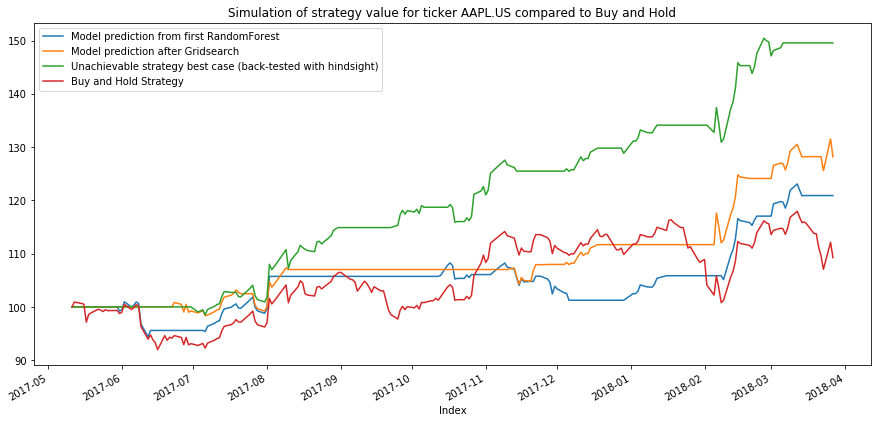


calculating backtest for: INTC.US
Performance of Model prediction from first RandomForest :    25.99%
Performance of Model prediction after Gridsearch :    10.78%
Performance of Unachievable strategy best case (back-tested with hindsight) :    96.52%
Performance of Buy and Hold Strategy :    46.07%


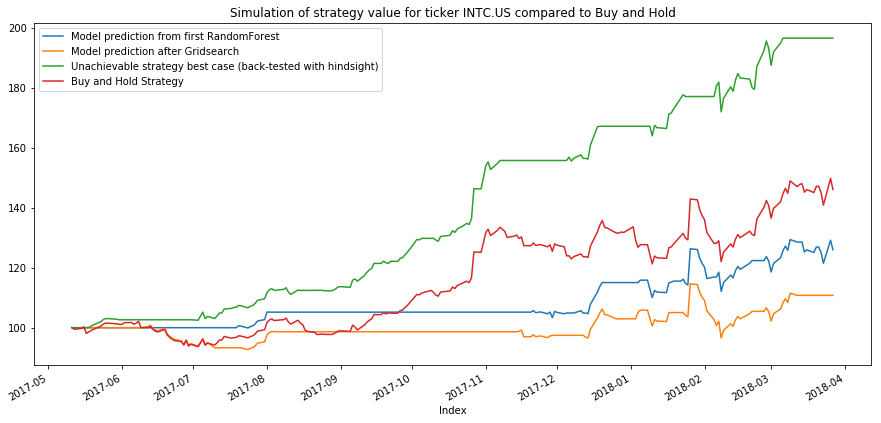


calculating backtest for: MSFT.US
Performance of Model prediction from first RandomForest :     1.37%
Performance of Model prediction after Gridsearch :    13.30%
Performance of Unachievable strategy best case (back-tested with hindsight) :    51.70%
Performance of Buy and Hold Strategy :    32.50%


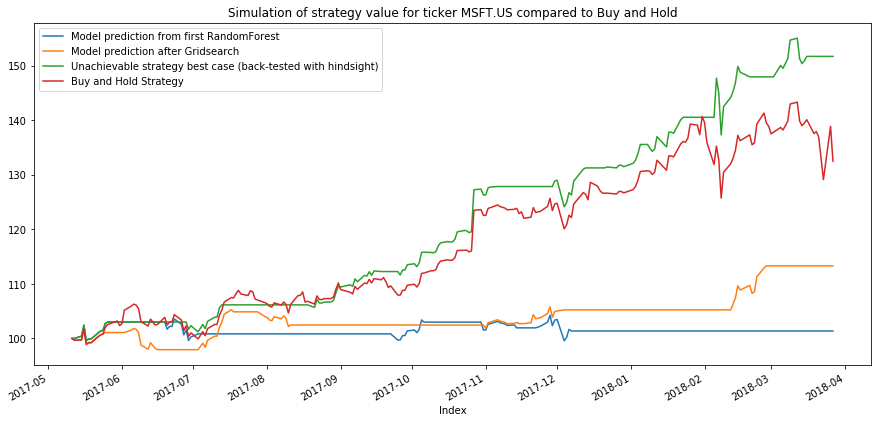


calculating backtest for: AMZN.US
Performance of Model prediction from first RandomForest :    14.12%
Performance of Model prediction after Gridsearch :    21.07%
Performance of Unachievable strategy best case (back-tested with hindsight) :    86.64%
Performance of Buy and Hold Strategy :    56.84%


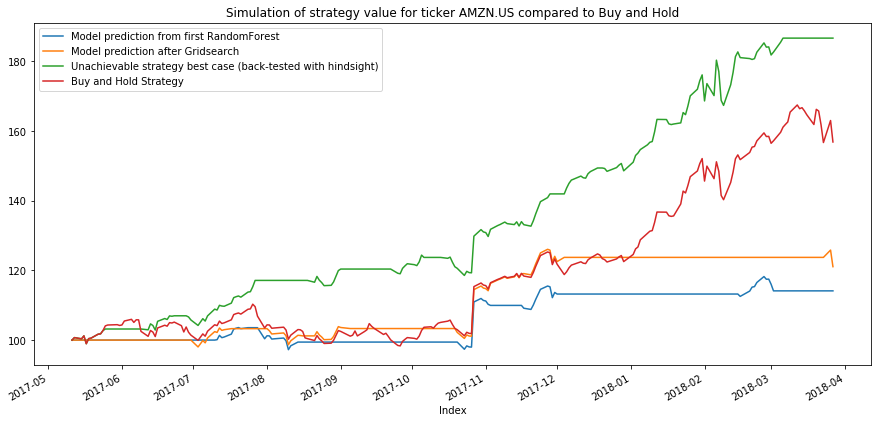


calculating backtest for: CSCO.US
Performance of Model prediction from first RandomForest :    20.47%
Performance of Model prediction after Gridsearch :     3.09%
Performance of Unachievable strategy best case (back-tested with hindsight) :    70.42%
Performance of Buy and Hold Strategy :    29.32%


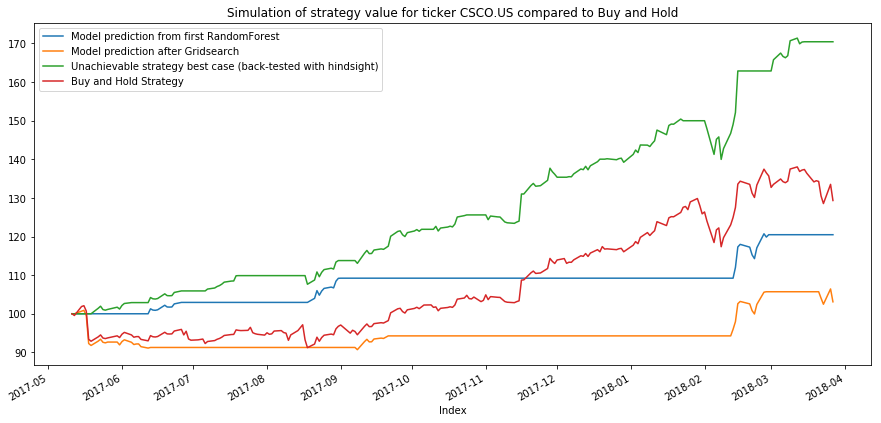


calculating backtest for: NFLX.US
Performance of Model prediction from first RandomForest :    52.94%
Performance of Model prediction after Gridsearch :     9.83%
Performance of Unachievable strategy best case (back-tested with hindsight) :   148.36%
Performance of Buy and Hold Strategy :    88.98%


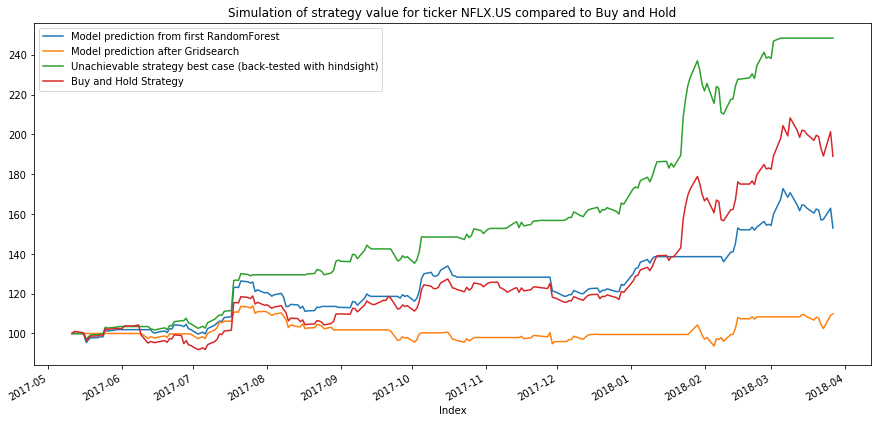


calculating backtest for: ABBV.US
Performance of Model prediction from first RandomForest :    -4.43%
Performance of Model prediction after Gridsearch :    13.92%
Performance of Unachievable strategy best case (back-tested with hindsight) :   108.70%
Performance of Buy and Hold Strategy :    43.22%


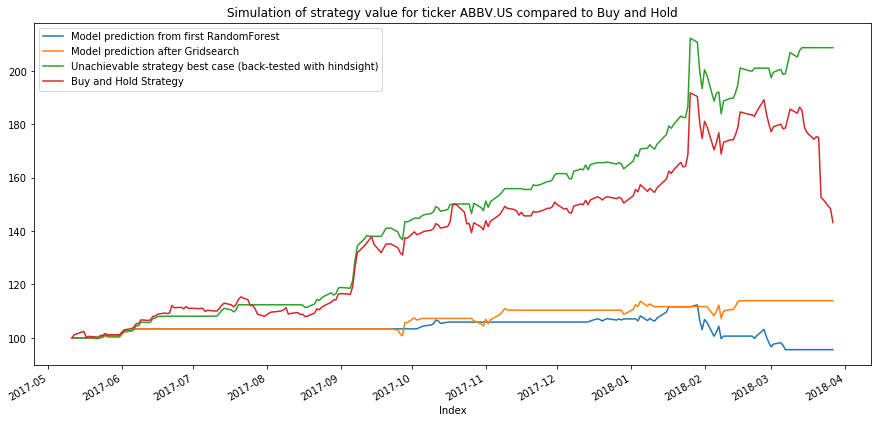


calculating backtest for: GE.US
Performance of Model prediction from first RandomForest :   -44.96%
Performance of Model prediction after Gridsearch :   -49.54%
Performance of Unachievable strategy best case (back-tested with hindsight) :    22.77%
Performance of Buy and Hold Strategy :   -51.74%


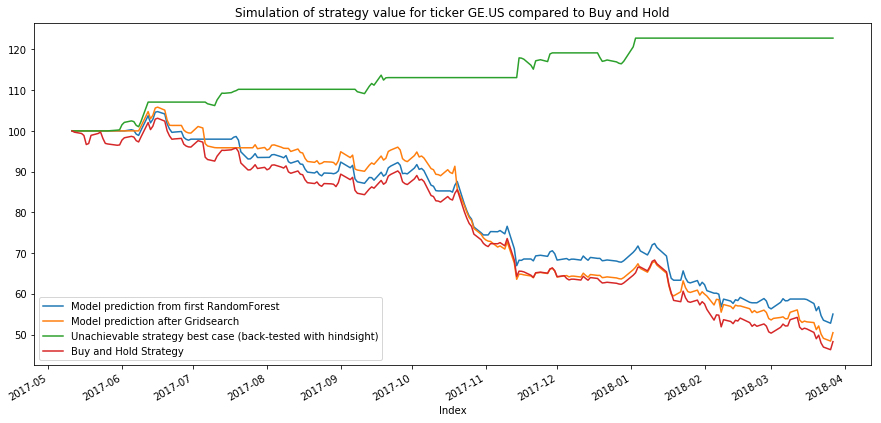

In [30]:
# cycle through all tickers and calculate performance of prediction for each
for ticker in tqdm_notebook(symbols):
    print('calculating backtest for: ' + ticker)
   
    # make list of the columns we will run through in the backtest:
    backtest_cols_list = backtest_col_meta.index.values.tolist() # all the simulations and backtests
    col_list = backtest_cols_list.copy() # need a copy so we can use backtest_cols_list later to cycle through for backtesting
    col_list.append(ticker) # the stock ticker for this iteration

    # pull out all rows for current ticker - and use the column list built above
    df_backtest_this_ticker = df_backtest.loc[df_backtest[ticker]==1, col_list] 
    
    ##### 1) get the downloaded stock data for this ticker and for the dates that will be part of the backtest
       
    # pull out the data for current ticker
    df_downloaded_data_this_ticker = df_downloaded_all_tickers.loc[ df_downloaded_all_tickers['ticker']==ticker, :]
    # now ensure we only use the same dates as in the backtest for this ticker
    df_downloaded_data_this_ticker_backtest_dates = df_downloaded_data_this_ticker.loc[df_backtest_this_ticker.index, :]
    
    # ensure same dates in index
    assert (df_backtest_this_ticker.index == df_downloaded_data_this_ticker_backtest_dates.index).all
    # ensure we got the right rows from the downloaded data for this stock
    assert (ticker == df_downloaded_data_this_ticker_backtest_dates['ticker']).all
    
    # now that we know we have the right data, keep only most important columns
    df_downloaded_data_this_ticker_backtest_dates = df_downloaded_data_this_ticker_backtest_dates[['AdjOpen', 'AdjClose', 
                                                                                                  'AdjHigh', 'AdjLow', 'ticker']]
    
    # build dataframe that has downloaded data and prediction and true strategy result for backtest time period
    df_backtest_this_ticker_with_downloaded_data = df_backtest_this_ticker.join(df_downloaded_data_this_ticker_backtest_dates)
    
    ###### we now have the dataframe with the original stock price data and a prediction column

    backtest_df = df_backtest_this_ticker_with_downloaded_data

    # cycle through the backtest_cols_list and calculate the backtest results for each
    for col_to_backtest in backtest_cols_list:
        backtest_df = calculate_backtest(backtest_df, col_to_backtest, 
                                     buy_on_day_plus_x = backtest_col_meta.loc[col_to_backtest, 'buy_on_day_plus_x'],
                                     sell_on_day_plus_x = backtest_col_meta.loc[col_to_backtest, 'sell_on_day_plus_x'],
                                     verbose=False)
        
        print('Performance of {0:} : {1:8.2f}%'.format(
            backtest_col_meta.loc[col_to_backtest, 'description'],
            backtest_df[backtest_col_meta.loc[col_to_backtest, 'value_col_name']][-1]-100)
             )
        
    show_chart_of_backtest_result(backtest_df, cols_to_plot = backtest_cols_list)

    print('')
       
    
    

In [ ]:
backtest_df.head()

## use TPOT